In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import img_to_array

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Paths to video folders
shop_lifters_path = '/content/drive/My Drive/Shop_DataSet/shop_lifters'
non_shop_lifters_path = '/content/drive/My Drive/Shop_DataSet/non_shop_lifters'

# Create DataFrame with file paths and labels
def create_video_dataframe():
    data = []
    for folder, label in [(shop_lifters_path, 1), (non_shop_lifters_path, 0)]:
        for filename in os.listdir(folder):
            if filename.endswith('.mp4'):
                data.append((os.path.join(folder, filename), label))
    return pd.DataFrame(data, columns=['video_path', 'label'])

df = create_video_dataframe()

In [ ]:
df

,video_path,label
0,/content/drive/My Drive/Shop_DataSet/shop_lift...,1
1,/content/drive/My Drive/Shop_DataSet/shop_lift...,1
2,/content/drive/My Drive/Shop_DataSet/shop_lift...,1
3,/content/drive/My Drive/Shop_DataSet/shop_lift...,1
4,/content/drive/My Drive/Shop_DataSet/shop_lift...,1
...,...,...
850,/content/drive/My Drive/Shop_DataSet/non_shop_...,0
851,/content/drive/My Drive/Shop_DataSet/non_shop_...,0
852,/content/drive/My Drive/Shop_DataSet/non_shop_...,0
853,/content/drive/My Drive/Shop_DataSet/non_shop_...,0


In [ ]:
# Split dataset into train (70%), validation (15%), and test (15%)
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label'])

# Function to extract video clips with uniform frames
def extract_video_clip(video_path, frames_per_clip=16, frame_size=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)
        frame = img_to_array(frame) / 255.0  # Normalize
        frames.append(frame)
    cap.release()

    total_frames = len(frames)

    if total_frames == 0:
        return np.zeros((frames_per_clip, *frame_size, 3))

    # If fewer frames, repeat frames to match
    if total_frames < frames_per_clip:
        frames = frames + frames[:frames_per_clip - total_frames]

    # If more frames, sample uniformly
    indices = np.linspace(0, total_frames - 1, frames_per_clip).astype(int)
    frames = [frames[i] for i in indices]

    return np.array(frames)

# Load dataset dynamically
def load_data(df):
    X, y = [], []
    for _, row in df.iterrows():
        video_clip = extract_video_clip(row['video_path'])
        X.append(video_clip)
        y.append(row['label'])
    return np.array(X), np.array(y)


In [ ]:
X_val, y_val = load_data(df_val)
X_test, y_test = load_data(df_test)

In [ ]:
# Reshape input for 3D CNN
X_train = X_train.reshape((-1, 16, 64, 64, 3))
X_val = X_val.reshape((-1, 16, 64, 64, 3))
X_test = X_test.reshape((-1, 16, 64, 64, 3))


In [ ]:
# Define 3D CNN model
model = Sequential([
    Conv3D(32, (3, 3, 3), activation='relu', input_shape=(16, 64, 64, 3)),
    MaxPooling3D((2, 2, 2)),
    Conv3D(64, (3, 3, 3), activation='relu'),
    MaxPooling3D((2, 2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history=model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_val, y_val))


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9922 - val_loss: 0.0091
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9977 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 2.3256e-04
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 5.0247e-04
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.8810e-04 - val_accuracy: 1.0000 - val_loss: 3.4695e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 1.0000 - loss: 5.2708e-04 - val_accuracy: 1.0000 - val_loss: 5.3702e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.7086e-04 - val_accuracy: 1.0000 - val_loss: 7.8622e-06
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 1.0000 - loss: 3.1629e-04 - val_accuracy: 1.0000 - val_loss: 1.0116e-06
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 -

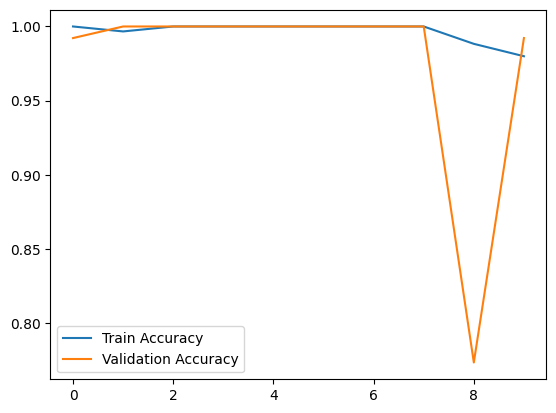

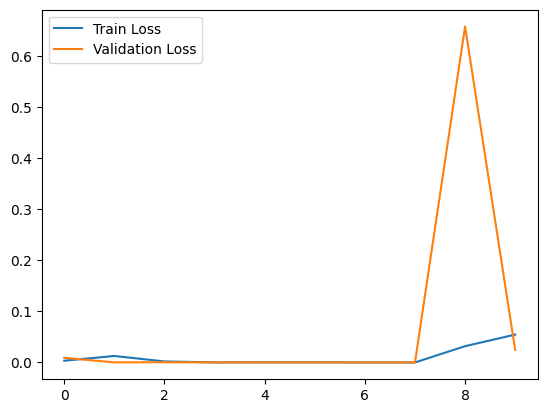

In [ ]:
import matplotlib.pyplot as plt
# Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()